# Binning reflectivity by height

I write a function that will take a raster image of values of interest and a raster image of altitudes above the ground as input and will return the reflectivity binned by height.

In this version, I mask the input data and the altitude raster to only contain the values near the transect flown by Jackson et al (2008). The idea is that the masked data should be more comparable to the data reported in Jackson et al (2008) that we are using as a test for our approach.

In [89]:
import rasterio as rast
from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import geopandas as gp
from shapely.geometry import Point, LineString, Polygon

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    pl.ion()

In [142]:
def BinnedRefl(altrast1, dBZrast1, lower1, upper1, width1):
    """This function takes an altitude raster, a dBZ raster, and some scalar arguments that dictate how the altitudinal bins are set up: 
    lower1 is the cntre of the lowest bin, upper1 is the centre of the highest bin, and width in the bin width. Note that when upper1 - lower1
    is divided by width1, we should obtain an integer number of bins. If this is not the case, the algorithm makes it so.
    
    Note also that the altrast1 and dBZrast1 arrays must have the same dimension, otherwise this won't work"""
    # First replacing values less than or equal to -32.0 in the reflectivity array with nan
    dBZrast1[dBZrast1 <= -32.0] = np.nan

    nbins = int(np.floor((upper1 - lower1)/width1)) # calculating the number of bins
    bincentres = np.linspace(lower1, upper1, num = nbins + 1) # bin centres
    upperarray = np.array(upper1 + np.floor(width1/2)) # an array for only the last value
    binbounds = np.hstack((bincentres - np.floor(width1/2), upperarray)) # bounds on all bins (lower and upper)
    digitized = np.digitize(altrast1, binbounds) # extracting indices
    dBZ_means = [np.nanmean(dBZrast1[digitized == i]) for i in range(1, len(binbounds))]
    return(bincentres, dBZ_means)

Reading in some reflectivity data to try the function.

In [143]:
indir1 = "/home/devingoodsman/Desktop/MPB Doppler/July262005Brasters/200507262150~~DOPVOL1_B:URP:XPG:RADAR:IRIS"
r1 = rast.open(indir1)
dBZ1 = r1.read(1)
print(r1.crs)
r1.close()

EPSG:3005


(-223.55978220468387, -224.7265061873477)
BoundingBox(left=1312752.7494675263, bottom=1073133.058641902, right=1089192.9672628425, top=848406.5524545542)


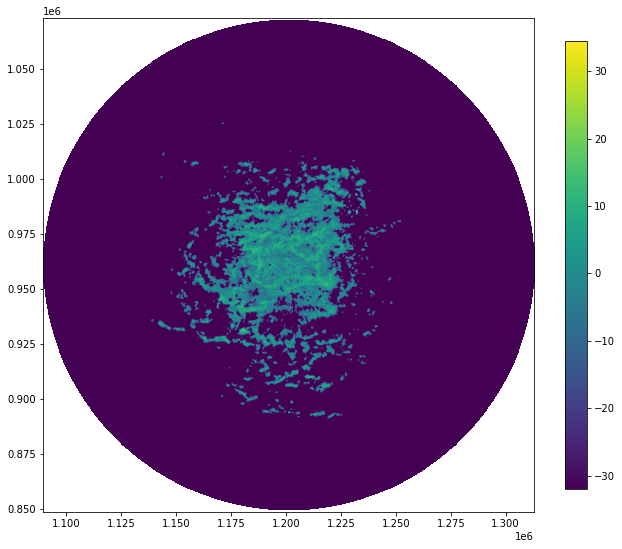

In [144]:
# plotting the raster
print(r1.res)
print(r1.bounds)
resx = r1.res[0]
resy = r1.res[1]
x0 = r1.bounds[2]
y0 = r1.bounds[1]
transform1 = Affine.translation(x0 - resx / 2, y0 - resy / 2) * Affine.scale(-resx, resy)
fig, ax = pl.subplots(figsize=(11, 11))
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(np.flip(dBZ1))

# plot on the same axis with rast.plot.show
im = rast.plot.show(np.flip(dBZ1), transform=transform1, ax=ax)
fig.colorbar(image_hidden, ax=ax, shrink = 0.75)

Creating the transect

In [145]:
transect = gp.GeoSeries([LineString([(-122.8667, 53.73333), (-123.0167, 53.41667)])])

# setting projection and then reprojecting to the same coordinate referenc system as the raster data
transect = transect.set_crs(epsg=4326)
print(transect.crs)
transect = transect.to_crs(epsg=3005)
print(transect.crs)

epsg:4326
epsg:3005


In [146]:
print(transect)

0    LINESTRING (1206161.598 974412.743, 1197786.73...
dtype: geometry


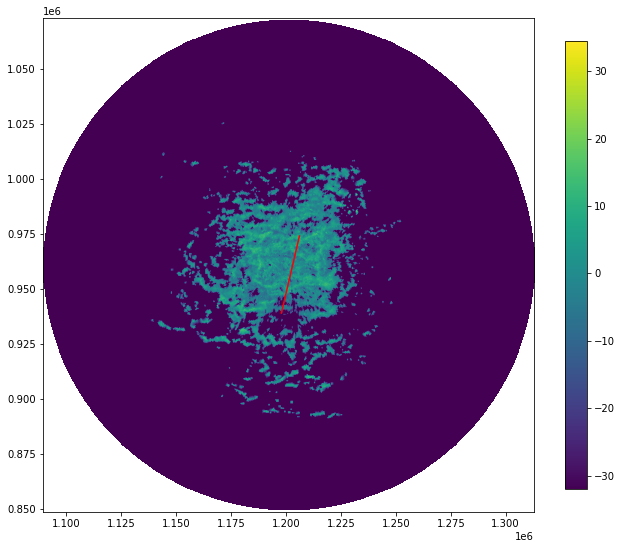

In [147]:
fig, ax = pl.subplots(figsize=(11, 11))
transect.plot(ax=ax, facecolor='none', edgecolor='red')
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(np.flip(dBZ1))

# plot on the same axis with rast.plot.show
im = rast.plot.show(np.flip(dBZ1), transform=transform1, ax=ax)
#transect.plot(ax=ax, facecolor='none', edgecolor='red')
fig.colorbar(image_hidden, ax=ax, shrink = 0.75)

This looks about right.

Making a buffer around the transect.

In [148]:
tsbuffer = transect.buffer(5000)

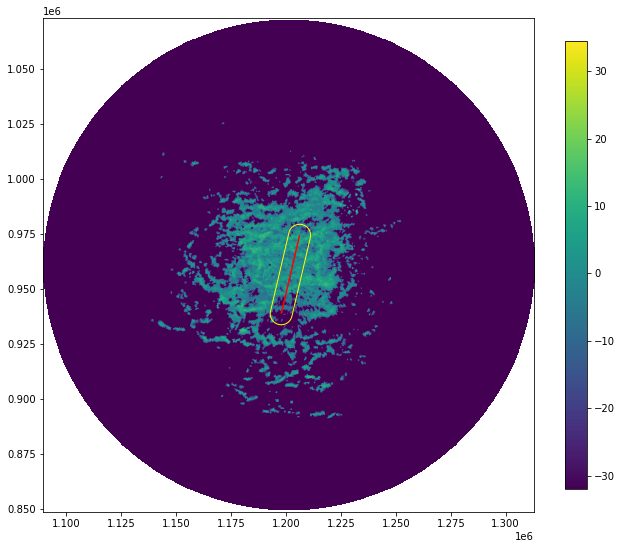

In [149]:
fig, ax = pl.subplots(figsize=(11, 11))
transect.plot(ax=ax, facecolor='none', edgecolor='red')
tsbuffer.plot(ax=ax, facecolor='none', edgecolor='yellow')
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(np.flip(dBZ1))

# plot on the same axis with rast.plot.show
im = rast.plot.show(np.flip(dBZ1), transform=transform1, ax=ax)
#transect.plot(ax=ax, facecolor='none', edgecolor='red')
fig.colorbar(image_hidden, ax=ax, shrink = 0.75)

Reading in the altitudinal data:

In [150]:
indir2 = "/home/devingoodsman/Desktop/MPB Doppler/July262005Brasters/BeamAltAboveGround.tif"
r2 = rast.open(indir2)
Altrast = r2.read(1)
r2.close()

## masking to include only transect

In [151]:
indir1 = "/home/devingoodsman/Desktop/MPB Doppler/July262005Brasters/200507262150~~DOPVOL1_B:URP:XPG:RADAR:IRIS"
r1 = rast.open(indir1)
r1mask = mask(r1, tsbuffer, crop = False)
r1.close()

indir2 = "/home/devingoodsman/Desktop/MPB Doppler/July262005Brasters/BeamAltAboveGround.tif"
r2 = rast.open(indir2)
r2mask = mask(r2, tsbuffer, crop = False)
r2.close()

Checking dimensionality

In [137]:
print(r1mask[0].shape)
print(r2mask[0].shape)

(3, 1000, 1000)
(1, 1000, 1000)


The second element contain the transformation.

In [101]:
r1mask[1]

Affine(-223.55978220468387, 0.0, 1211256.6083465999,
       0.0, 224.7265061873477, 933577.898299559)

In [102]:
r2mask[1]

Affine(-224.05776585824788, 0.0, 1211279.3295266288,
       0.0, 225.2276260299841, 933517.3575426376)

In [103]:
transform1

Affine(223.55978220468387, 0.0, 1089304.7471539448,
       0.0, -224.7265061873477, 1073245.4218949955)

In [152]:
# grabbing just reflectivity layer
dBZ1mask = r1mask[0][0,:,:]
print(dBZ1mask.shape)

# grabbing only layer of altitude data
Altmask = r2mask[0][0,:,:]
print(Altmask.shape)

(1000, 1000)
(1000, 1000)


Plotting the raster data

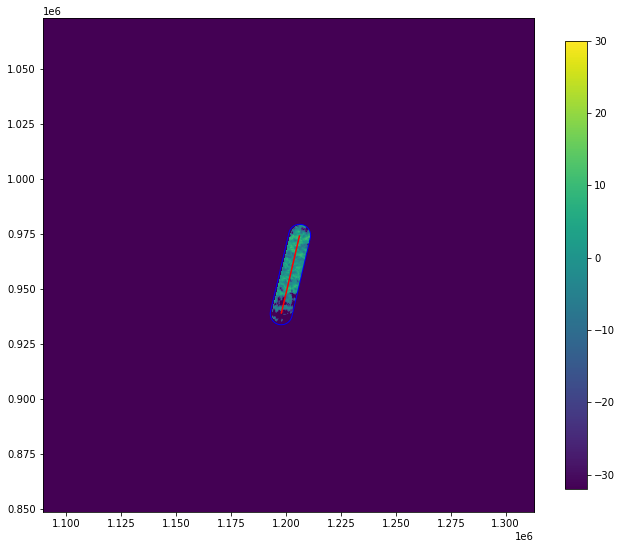

In [153]:
fig, ax = pl.subplots(figsize=(11, 11))
transect.plot(ax=ax, facecolor='none', edgecolor='red')
tsbuffer.plot(ax=ax, facecolor='none', edgecolor='blue')
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(np.flip(dBZ1mask), vmin = -32.0, vmax = 30.0)

# plot on the same axis with rast.plot.show
im = rast.plot.show(np.flip(dBZ1mask), transform=transform1, ax=ax, vmin = -32.0, vmax = 30.0)
#transect.plot(ax=ax, facecolor='none', edgecolor='red')
fig.colorbar(image_hidden, ax=ax, shrink = 0.75)

Trying out the binning function

In [154]:
altbins, reflects = BinnedRefl(altrast1 = Altmask, dBZrast1 = dBZ1mask, lower1 = 120, upper1 = 720, width1 = 150)

/tmp/ipykernel_213088/3323429658.py:15: RuntimeWarning: Mean of empty slice
  dBZ_means = [np.nanmean(dBZrast1[digitized == i]) for i in range(1, len(binbounds))]


Now plotting to see if results are what we would expect.

Text(0, 0.5, 'reflectivity (logarithmic scale)')

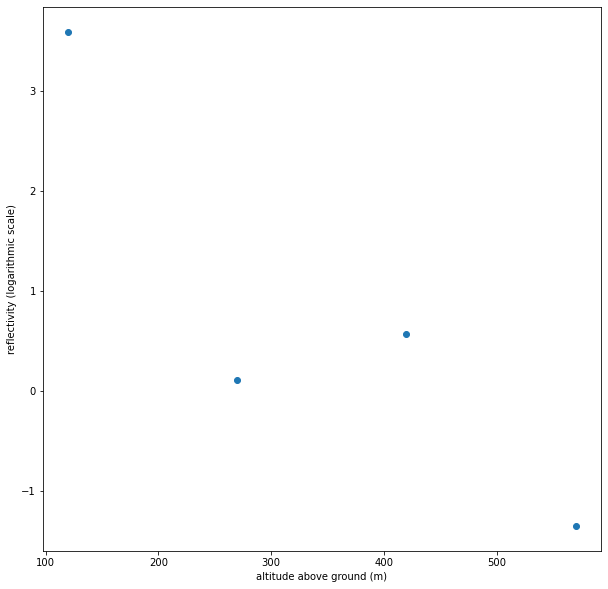

In [155]:
fig = pl.figure(figsize=(10, 10))
pl.scatter(altbins, reflects)
pl.xlabel("altitude above ground (m)")
pl.ylabel("reflectivity (logarithmic scale)")

This is closer to the negative linear relationship that we are expecting than when we looked everywhere and not just along the transect, but it is still not there...